In this notebook we look at the subgroups FP, FN, TP/N wrt. is_recid. To that end, we train a model for each option, trying to predict subgroup.

In [20]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import sys
import copy
import torch
import pandas as pd
import matplotlib
from enum import Enum
from tqdm import tqdm
from collections import OrderedDict 
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import svm, preprocessing, tree, ensemble
from sklearn.metrics import mean_squared_error

# Don't truncate column lists
pd.options.display.max_columns = None

# Add code path to look for files to import
code_path = os.path.abspath('..')
base_path = os.path.join(code_path, '..')
if code_path not in sys.path:
    sys.path.append(code_path)
    
import ml_utils
import plot_helpers
import process_data
from models import ModelType
from train import fit_any


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset and Preprocessing

In [21]:
dataset = "_reduced_size"

## Dataset and Preprocessing
data = process_data.Data_set(base_path, dataset, overwrite=False)
data.setup_data(cutoff = 4, cuttype = 'decile_score', min_val=0, max_val=1, strat=None, variable_dependent=False)

X_train, X_val, X_test, y_train, y_val, y_test = data.select_data(
                    #y_to_X = ['Risk of Recidivism_decile_score/10', 'Risk of Recidivism_raw_score','Risk of Violence_decile_score/10', 'Risk of Violence_raw_score', ]
                     y_to_X = [],#['Risk of Violence_decile_score/10']#, 'Risk of Violence_raw_score', ]
                    )

to_drop = ['Risk of Recidivism_score_text', 'Risk of Violence_score_text', 'Risk of Failure to Appear_score_text']
y_train.drop(labels=to_drop, axis = 1, inplace=True)
y_val.drop(labels=to_drop, axis = 1, inplace=True)
y_test.drop(labels=to_drop, axis = 1, inplace=True)

#do_drop_X = ['recid_corr', 'recid_violent_corr', 'custody_days_jail', 'custody_days_jail_viol', 'jail_sentences', 'jail_sentences_viol', 'custody_days_prison', 'prison_sentences', 'custody_days_prison_viol', 'prison_sentences_viol']
#X_train.drop(labels=do_drop_X, axis = 1, inplace=True)
#X_val.drop(labels=do_drop_X, axis = 1, inplace=True)
#X_test.drop(labels=do_drop_X, axis = 1, inplace=True)

use iterative marker...
done with setting up the data set...


In [22]:
X_train.columns

Index(['offenses_within_30', 'p_felony_count_person', 'p_misdem_count_person',
       'p_charge_violent', 'p_current_age', 'p_age_first_offense',
       'p_juv_fel_count', 'p_felprop_violarrest', 'p_murder_arrest',
       'p_felassault_arrest', 'p_misdemassault_arrest', 'p_sex_arrest',
       'p_weapons_arrest', 'p_n_on_probation', 'p_current_on_probation',
       'p_prob_revoke', 'p_arrest', 'p_jail30', 'p_prison30', 'p_prison',
       'p_probation', 'is_misdem', 'race_black', 'race_white', 'race_hispanic',
       'race_asian', 'race_native', 'is_married', 'is_divorced', 'is_widowed',
       'is_separated', 'is_sig_other', 'is_marit_unknown', 'is_male'],
      dtype='object')

In [23]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

3239
1080
1440


In [24]:
def visualize_relevance(labels, relevance, target_label):
    plt.figure(figsize=(8,8))
    plt.barh(labels, relevance, height=1)
    plt.title(target_label)
    plt.xlabel("Linear model coefficients");
    plt.show()
    
def visualize_model(model_type: ModelType, model, X_train):
    if model_type == ModelType.NN:
        pass
    elif model_type == ModelType.SVM:
        visualize_relevance(X_train.columns, model.coef_[0], target)
        
    elif model_type == ModelType.DT:
        plt.figure(figsize=(14,14))
        tree.plot_tree(model, feature_names=X_train.columns, filled=True)
        plt.show()
        
    elif model_type == ModelType.RF:
        visualize_relevance(X_train.columns, model.feature_importances_, target)

## Model Training on the subgroups 

In [25]:
keys = ['group_recid']
subkeys = ['FP']#, 'FN']
subset = X_train.columns
#subset = ['p_misdem_count_person', 'p_current_age', 'p_felassault_arrest', 'p_arrest', 'is_male']#['Risk of Violence_decile_score/10']
restrict_dataset = True
weighting = False

In [26]:
configs = {
    ModelType.NN: {
        "activation": torch.nn.ReLU,
        "n_layers": 4,
        "n_hidden": 30,
        "batch_size": 256,
        "lr": 0.01,
        "weight_decay": 0.0,
        "n_epochs": 100
        },
    ModelType.DT: {
        "criterion": "gini",
        "max_depth": 3
    },
    ModelType.RF: {
        "n_estimators": 100,
        "criterion": "gini",
        "max_depth": 4
    },
    ModelType.SVM: {
        "penalty": "l2",
        "C": 1.,
        "dual": False
    }
}

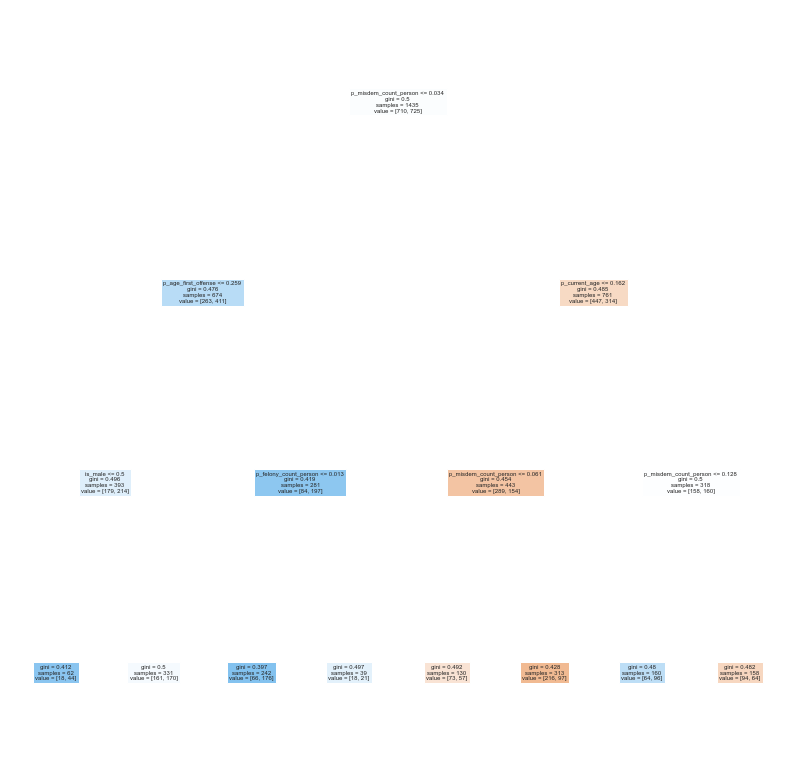

DT RMSE: 0.6139003678694415 correct: 0.6231263383297645 correct(rel): 0.6231263383297645
group_recid_FP
####################################################################################


In [27]:
model_types = [ModelType.DT]#[ModelType.SVM, ModelType.DT, ModelType.RF, ModelType.NN]
errors_rmse = {m:{} for m in model_types}
correct_frac = {m:{} for m in model_types}
correct_frac_sub = {m:{} for m in model_types}
y_val_predicted = {m:{} for m in model_types}
y_test_predicted = {m:{} for m in model_types}
y_test_predicted_t = {m:{} for m in model_types}
error_reduction = {m:{} for m in model_types}

# FP models
for model_type in model_types:
    models = {}
    config = configs[model_type]
    
    for key in keys:
        for subkey in subkeys:
            target = key + '_' + subkey
            original_target_name = target

            data_subkey = key + ('_P' if 'P' in subkey else '_N')
            idcs_tr = y_train[data_subkey]
            idcs_te = y_test[data_subkey]
            idcs = y_val[data_subkey]
            if restrict_dataset:
                X_train_sub = X_train[idcs_tr]
                y_train_sub = y_train[idcs_tr] 
                X_val_sub = X_val[idcs]
                y_val_sub = y_val[idcs]  
                X_test_sub = X_test[idcs_te]
                y_test_sub = y_test[idcs_te] 
            else:
                X_train_sub = X_train
                y_train_sub = y_train 
                X_val_sub = X_val
                y_val_sub = y_val
                X_test_sub = X_test
                y_test_sub = y_test
                
            model, y_val_predicted_pos, _ = fit_any(model_type, X_train_sub[subset], X_val_sub[subset], y_train_sub, y_val_sub, target, config, weighting)
            _, y_test_predicted_pos, _ = fit_any(model_type, X_train_sub[subset], X_test_sub[subset], y_train_sub, y_test_sub, target, config, weighting)

            models[target] = model
            visualize_model(model_type, model, X_train_sub[subset])

            y_val_predicted[model_type][target] = y_val_predicted_pos
            y_test_predicted[model_type][target] = y_test_predicted_pos
            y_test_predicted_t[model_type][target] = np.array([1 if y > (0 if model_type == ModelType.NN else 0.5) else 0 for y in y_test_predicted[model_type][target]])
            y_val_predicted_t = np.array([1 if y > (0 if model_type == ModelType.NN else 0.5) else 0 for y in y_val_predicted[model_type][target]])
            
            # calculate error terms
            rmse = mean_squared_error(y_val_sub[target], y_val_predicted_pos, squared=False)
            errors_rmse[model_type][target] = rmse
            correct = np.array([int(y_val_sub[target][i] == y_val_predicted_t[i]) for i in range(len(y_val_predicted_t))])
            correct_frac[model_type][target] = sum(correct)/len(correct)
            if restrict_dataset:
                correct_frac_sub[model_type][target] =  correct_frac[model_type][target]
                error_reduction[model_type][target] = sum(correct* y_val_predicted_t * y_val[idcs][target]) # relevant positive correct
                error_reduction[model_type][target] += sum(np.invert(correct) * y_val_predicted_t * (~y_val[idcs][target])) # relevant positive false
            else:
                print("#correct = %d, all = %d" %(sum(correct[idcs]), sum(idcs)))
                correct_frac_sub[model_type][target] = sum(correct[idcs])/sum(idcs)
                error_reduction[model_type][target] = sum(correct[idcs] * y_val_predicted_t[idcs] * y_val[idcs][target]) # relevant positive correct
                error_reduction[model_type][target] += sum(np.invert(correct[idcs]) * y_val_predicted_t[idcs] * (~y_val[idcs][target])) # relevant negative false

            print(model_type.name, "RMSE:", rmse, "correct:", correct_frac[model_type][target], "correct(rel):", correct_frac_sub[model_type][target])
            print(target)
            print("####################################################################################")


In [28]:
# Adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

clf = models["group_recid_FP"]

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has {n} nodes.:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} is a leaf node.".format(
            space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node}: "
              "node {left} if {feature} <= {threshold} "
              "else node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=X_train_sub[subset].columns[feature[i]],
                  threshold=data.min_vals[X_train_sub[subset].columns[feature[i]]] + threshold[i] * data.max_vals[X_train_sub[subset].columns[feature[i]]],
                  right=children_right[i]))


The binary tree structure has 15 nodes.:

node=0: node 1 if p_misdem_count_person <= 2.4999999571591616 else node 8.
	node=1: node 2 if p_age_first_offense <= 20.50000062584877 else node 5.
		node=2: node 3 if is_male <= 0.5 else node 4.
			node=3 is a leaf node.
			node=4 is a leaf node.
		node=5: node 6 if p_felony_count_person <= 1.4999999315477908 else node 7.
			node=6 is a leaf node.
			node=7 is a leaf node.
	node=8: node 9 if p_current_age <= 32.259740114212036 else node 12.
		node=9: node 10 if p_misdem_count_person <= 4.499999936670065 else node 11.
			node=10 is a leaf node.
			node=11 is a leaf node.
		node=12: node 13 if p_misdem_count_person <= 9.499999850988388 else node 14.
			node=13 is a leaf node.
			node=14 is a leaf node.


In [29]:
feature

array([ 2,  5, 33, -2, -2,  1, -2, -2,  4,  2, -2, -2,  2, -2, -2],
      dtype=int64)

In [30]:
X_train_sub[subset].columns

Index(['offenses_within_30', 'p_felony_count_person', 'p_misdem_count_person',
       'p_charge_violent', 'p_current_age', 'p_age_first_offense',
       'p_juv_fel_count', 'p_felprop_violarrest', 'p_murder_arrest',
       'p_felassault_arrest', 'p_misdemassault_arrest', 'p_sex_arrest',
       'p_weapons_arrest', 'p_n_on_probation', 'p_current_on_probation',
       'p_prob_revoke', 'p_arrest', 'p_jail30', 'p_prison30', 'p_prison',
       'p_probation', 'is_misdem', 'race_black', 'race_white', 'race_hispanic',
       'race_asian', 'race_native', 'is_married', 'is_divorced', 'is_widowed',
       'is_separated', 'is_sig_other', 'is_marit_unknown', 'is_male'],
      dtype='object')

In [31]:
len(X_train_sub[subset].columns)

34

In [32]:
[X_train_sub[subset].columns[f] for f in feature]

['p_misdem_count_person',
 'p_age_first_offense',
 'is_male',
 'is_marit_unknown',
 'is_marit_unknown',
 'p_felony_count_person',
 'is_marit_unknown',
 'is_marit_unknown',
 'p_current_age',
 'p_misdem_count_person',
 'is_marit_unknown',
 'is_marit_unknown',
 'p_misdem_count_person',
 'is_marit_unknown',
 'is_marit_unknown']

In [33]:
def print_dict(d, name=None):
    if name is not None:
        print("\n------------", name, "------------")
    for k,v in d.items():
        print(k)
        for kk, vv in v.items():
            print("\t%s %.2f" % (kk, vv))

In [34]:
#print_dict(errors_rmse,"RMSE")
print_dict(error_reduction,"Total Error Reduction")
print_dict(correct_frac,"ACC")
print_dict(correct_frac_sub,"ACC on relevant")


------------ Total Error Reduction ------------
ModelType.DT
	group_recid_FP 58.00

------------ ACC ------------
ModelType.DT
	group_recid_FP 0.62

------------ ACC on relevant ------------
ModelType.DT
	group_recid_FP 0.62


### Local Relevance (NN)

In [35]:
# Only works if NN is trained last, at the moment
if False:
    device = "cpu"

    for c in y_train.columns:
        if "text" in c or "proPub" in c:
            y_train.drop(labels=c, axis = 1, inplace=True)
            y_val.drop(labels=c, axis = 1, inplace=True)
            y_test.drop(labels=c, axis = 1, inplace=True)

    for model_type in model_types:  
        if model_type == ModelType.NN:
            for key in keys:
                for subkey in subkeys:
                    target = key + '_' + subkey
                    print(target, model_type)
                    model = models[target]
                    expl_model = explain.make_explainable(copy.deepcopy(model)).to(device)

                    loader = torch.utils.data.DataLoader(PandasDataset(X_val[subset], y_val), batch_size=1, shuffle=False)

                    target_idx = list(y_val.columns).index(target)

                    Rs = []
                    ys = []
                    y_hats = []
                    n_examples = 5
                    for x_i, (x, y) in enumerate(loader):
                        y_hat = model(x).to(device)
                        y_hats.append(y_hat)
                        R = explain.grad(expl_model, x)[0,0].cpu().detach()
                        Rs.append(R)
                        ys.append(y[0,0])

                        if x_i < n_examples:
                            # Display an example explanation
                            print("Example: Subject", x_i)
                            print(target, "=", float(y[0,0,target_idx]), "\t prediction =", float(y_hat))
                            ml_utils.visualize_relevance(X_val[subset].columns, R, target)
                print("##############################################################")

ModelType.DT
Column ratios: 1.38, 0.75


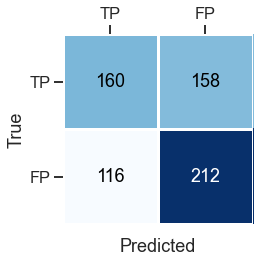

In [36]:
for model_type in model_types: 
    print(model_type)
    for key in keys:
        for subkey in subkeys:
            target = key + '_' + subkey
            cell_labels = ["T"+subkey[-1], subkey]
            
            data_subkey = key + ('_P' if 'P' in subkey else '_N')
            idcs_te = y_test[data_subkey]
            if restrict_dataset:
                X_test_sub = X_test[idcs_te]
                y_test_sub = y_test[idcs_te] 
            else:
                X_test_sub = X_test
                y_test_sub = y_test
            
            save = (model_type == ModelType.DT) and (subkey == "FP")
            plot_helpers.one_confusion_matrix(y_test_sub[target], y_test_predicted_t[model_type][target], None, cell_labels, save=save, file_postfix=subkey)
            #plot_helpers.confusion_matrices(keys, subkeys, y_val_predicted[model_type], y_val, (0 if model_type == ModelType.NN else 0.5), restrict_dataset=True)

In [37]:
def calculate_stats(y, y_hat):
    stats = {}
    stats["tp"] = sum([y_==1 and y_hat_==1 for (y_, y_hat_) in zip(y, y_hat)])
    stats["fp"] = sum([y_==0 and y_hat_==1 for (y_, y_hat_) in zip(y, y_hat)])
    stats["tn"] = sum([y_==0 and y_hat_==0 for (y_, y_hat_) in zip(y, y_hat)])
    stats["fn"] = sum([y_==1 and y_hat_==0 for (y_, y_hat_) in zip(y, y_hat)])
    stats["prec"] = 0 if ((stats["tp"] + stats["fp"]) == 0) else (stats["tp"] / (stats["tp"] + stats["fp"]))
    stats["rec"] = 0 if ((stats["tp"] + stats["fn"]) == 0) else (stats["tp"] / (stats["tp"] + stats["fn"]))
    stats["tpr"] = stats["rec"]
    stats["fpr"] = 0 if ((stats["fp"] + stats["tn"]) == 0) else (stats["fp"] / (stats["fp"] + stats["tn"]))
    stats["tnr"] = 1-stats["fpr"]
    stats["fnr"] = 1-stats["tpr"]
    stats["acc"] = (stats["tp"] + stats["tn"]) / (len(y))
    #stats["f1"] = 2 * (stats["prec"] * stats["rec"]) / (stats["prec"] + stats["rec"])
    return stats

In [38]:
for y_ in [y_train, y_val, y_test]:
    print("n samples:", len(y_))
    print("n recid:", sum(y_["recid"]))
    print("fraction recid:", sum(y_["recid"]) / len(y_))
    print("\n".join([k + ": " + str(v) for k,v in calculate_stats(y_["recid"], y_["group_recid_P"]).items()]))
    print("##################################")

n samples: 3239
n recid: 1184
fraction recid: 0.3655449212719975
tp: 710
fp: 725
tn: 1330
fn: 474
prec: 0.49477351916376305
rec: 0.5996621621621622
tpr: 0.5996621621621622
fpr: 0.35279805352798055
tnr: 0.6472019464720195
fnr: 0.40033783783783783
acc: 0.6298240197591849
##################################
n samples: 1080
n recid: 381
fraction recid: 0.3527777777777778
tp: 233
fp: 234
tn: 465
fn: 148
prec: 0.4989293361884368
rec: 0.6115485564304461
tpr: 0.6115485564304461
fpr: 0.33476394849785407
tnr: 0.6652360515021459
fnr: 0.38845144356955386
acc: 0.6462962962962963
##################################
n samples: 1440
n recid: 514
fraction recid: 0.35694444444444445
tp: 318
fp: 328
tn: 598
fn: 196
prec: 0.49226006191950467
rec: 0.6186770428015564
tpr: 0.6186770428015564
fpr: 0.3542116630669546
tnr: 0.6457883369330454
fnr: 0.38132295719844356
acc: 0.6361111111111111
##################################


In [39]:
def plot_ROC(stats_list, compas_stats=None, plot_acc=False, save=False, file_postfix=""):
    """
    Stats need to be passed in increasing order of FPR.
    """
    
    #Clean Stats of "loops"
    loop = True
    while loop:
        for s_i, s in enumerate(stats_list):
            if s_i > 0 and s["fpr"] < stats_list[s_i-1]["fpr"]:
                stats_list = stats_list[:s_i] + stats_list[s_i+1:]
                break
            if s_i == (len(stats_list)-1):
                loop = False
    
    sns.set_style("ticks")
    sns.set_context("talk")

    acc = [s["acc"] for s in stats_list]
    tpr = [s["tpr"] for s in stats_list]
    fpr = [s["fpr"] for s in stats_list]
    
    #plt.plot(fpr, tpr, color="blue")
    plt.step(fpr, tpr, where="post", color="blue")
    ax = plt.gca()
    
    # Plot compas marker
    if compas_stats is not None:
        ax.scatter([compas_stats["fpr"]], [compas_stats["tpr"]], marker="x", color="blue", label="COMPAS")
    
    # Plot accuracy
    if plot_acc:
        ax2 = ax.twinx()
        ax2.plot(fpr, acc, color="orange")
        #ax2.step(fpr, acc, where="post", color="orange")
        if compas_stats is not None:
            ax2.scatter([compas_stats["fpr"]], [compas_stats["acc"]], marker="x", color="orange", label="COMPAS")
        ax2.set_ylabel("Accuracy", color="orange")
        ax.set_ylabel("True Positive Rate", color="blue")
    else:
        ax.set_ylabel("True Positive Rate")

    minmax = min(max(tpr), max(fpr))*1.05
    ax.plot([0,minmax],[0,minmax], linestyle="dashed", linewidth=1, color='gray', label="Random")
    ax.set_xlabel("False Positive Rate")
    plt.xlim([0,max(fpr)*1.05])
    plt.ylim([0,(max(tpr+acc) if plot_acc else max(tpr))*1.05])
    ax.figure.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
    # ax.figure.legend(bbox_to_anchor = (0.8, 0.4))
    
    plt.tight_layout()
    
    if save:
        plt.savefig("ROC_%s.eps" % file_postfix, dpi=300, bbox_inches='tight')
    
    plt.show()

## ROC of bes model

Unweighted {'tp': 160, 'fp': 116, 'tn': 810, 'fn': 354, 'prec': 0.5797101449275363, 'rec': 0.311284046692607, 'tpr': 0.311284046692607, 'fpr': 0.12526997840172785, 'tnr': 0.8747300215982722, 'fnr': 0.688715953307393, 'acc': 0.6736111111111112} 



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


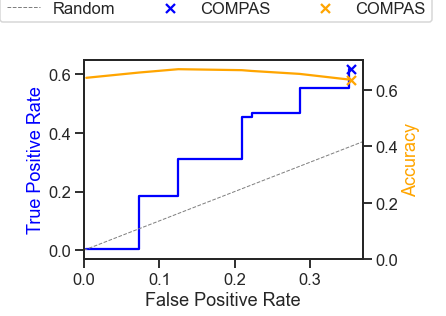

In [40]:
model_type = ModelType.DT
weights = [0.01] + [i*0.15 for i in range(1,25)]
config = configs[model_type]

for key in keys:
    true = y_test[key.split("_")[-1]]
    for subkey in subkeys:
        target = key + '_' + subkey
        compas_pred_key = key + '_P'
        data_subkey = key + '_' + subkey[-1]
        idcs_tr = y_train[data_subkey]
        idcs_val = y_val[data_subkey]
        idcs_test = y_test[data_subkey]
        if True:
            X_train_sub = X_train[idcs_tr]
            y_train_sub = y_train[idcs_tr] 
            X_val_sub = X_val[idcs_val]
            y_val_sub = y_val[idcs_val]  
            X_test_sub = X_test[idcs_test]
            y_test_sub = y_test[idcs_test] 
        else:
            X_train_sub = X_train
            y_train_sub = y_train 
            X_val_sub = X_val
            y_val_sub = y_val
            X_test_sub = X_test
            y_test_sub = y_test
            
        if subkey.endswith("FP"):
            weights=sorted(weights, reverse=True)
        else:
            weights=sorted(weights)


        # Without weighting:
        model, y_test_predicted_pos, _ = fit_any(model_type, X_train_sub[subset], X_test_sub[subset], y_train_sub, y_test_sub, target, config, None)
        y_test_predicted_t = np.array([1 if y > (0 if model_type == ModelType.NN else 0.5) else 0 for y in y_test_predicted_pos])
        if True:
            # Calc for whole set
            augmented = copy.deepcopy(y_test[compas_pred_key])
            if subkey[-1] == "P":
                augmented[idcs_test] = pd.Series([(not y_test_predicted_t[p]) * y_test_sub[compas_pred_key][p] for p in range(len(y_test_sub))], index=y_test_sub.index)
            else: #FN
                augmented[idcs_test] = pd.Series([y_test_predicted_t[p] * (not y_test_sub[compas_pred_key][p]) for p in range(len(y_test_sub))], index=y_test_sub.index)
            print("Unweighted", calculate_stats(true, augmented),"\n")
        else:
            # Calc for Positive only
            print("Unweighted", calculate_stats(y_test_sub[target], y_test_predicted_t),"\n")
        
        # Varying weights
        stats_list = []
        for w in weights:
            model, y_test_predicted_pos, _ = fit_any(model_type, X_train_sub[subset], X_test_sub[subset], y_train_sub, y_test_sub, target, config, w)
            y_test_predicted_t = np.array([1 if y > (0 if model_type == ModelType.NN else 0.5) else 0 for y in y_test_predicted_pos])

            if True:
                # Calc for whole set
                augmented = copy.deepcopy(y_test[compas_pred_key])
                if subkey[-1] == "P":
                    augmented[idcs_test] = pd.Series([(not y_test_predicted_t[p]) * y_test_sub[compas_pred_key][p] for p in range(len(y_test_sub))], index=y_test_sub.index)
                else: #FN
                    augmented[idcs_test] = pd.Series([y_test_predicted_t[p] * (not y_test_sub[compas_pred_key][p]) for p in range(len(y_test_sub))], index=y_test_sub.index)

                stats_list.append(calculate_stats(true, augmented))
            else:
                # Calc for Positive only
                stats_list.append(calculate_stats(y_test_sub[target], y_test_predicted_t))
                
            #print(w, stats_list[-1])
            
        plot_ROC(stats_list, compas_stats=calculate_stats(y_test['recid'], y_test[compas_pred_key]), plot_acc=True, save=True, file_postfix=subkey)

In [41]:
# At the moment only works for the last trained model
subgroup = "group_viol_FP"
if model_types[-1] == ModelType.NN:
    y_val_predicted_t = [1 if x >=.5 else 0 for x in list(torch.sigmoid(torch.tensor(y_val_predicted[subgroup])))]
else:
    y_val_predicted_t = [1 if x >=.5 else 0 for x in y_val_predicted[subgroup]]
    
y_val["outcome"] = y_val[subgroup]-y_val_predicted_t
y_val.loc[(y_val["outcome"] == 0) & (y_val["group_viol_FP"] == 1), "outcome"] = 0.5
y_val.loc[(y_val["outcome"] == 0) & (y_val["group_viol_FP"] == 0), "outcome"] = -0.5

val2label = {
    0.5:"FP detected",#"TP",
    -0.5:"TP,TN,FN detected",#"TN",
    1:"FP not detected",#"FN",
    -1:"TP,TN,FN not detected"#"FP"
}

for col_i, col in enumerate(X_val.columns):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
    legend = []
    for val in y_val["outcome"].unique():
        legend.append(val2label[val])#+"(%s)"%subgroup)
        X_vis_o = X_val[y_val["outcome"] == val]
        axs.hist(X_vis_o[col], alpha=0.75, density=True, bins = [0.1 * i for i in range(-10,11,2)])
        #axs.set_yscale('log')
        axs.set_xlabel(col)
    axs.legend(legend)
    plt.show()

KeyError: 'group_viol_FP'